In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('../Datasets/mini_shakespeare.txt', 'r', encoding='utf8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))
print(f"first 100 characters:\n{text[:100]}")

length of dataset in characters:  1115394
first 100 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

In [5]:
# create a mapping from character to integer and a reverse mapping
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda x: [stoi[ch] for ch in x]
decode = lambda x: ''.join([itos[i] for i in x])

print(encode('hello'))
print(decode(encode('hello')))

[46, 43, 50, 50, 53]
hello


In [6]:
data = torch.tensor(encode(text), dtype=torch.long).to(device)
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]
print(f"train data size: {train_data.size()}, validation data size: {val_data.size()}")

train data size: torch.Size([1003854]), validation data size: torch.Size([111540])


In [7]:
torch.manual_seed(42)
batch_size = 4
block_size = 8

def get_batch(val=False):
    data = train_data if not val else val_data
    idx = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in idx])
    y = torch.stack([data[i+1:i+block_size+1] for i in idx])
    return x, y

Xs, Ys = get_batch()
print(f'Xs: {Xs.shape}, Ys: {Ys.shape}')

Xs: torch.Size([4, 8]), Ys: torch.Size([4, 8])


In [8]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):

        logits = self.token_embedding_table(idx)
        loss = None

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
model = BigramLanguageModel(vocab_size).to(device)
losses = []

logits, loss = model(Xs, Ys)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long).to(device)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.7241, device='cuda:0', grad_fn=<NllLossBackward0>)

iF3E Ns;RpsbzqPdWDT-Rot'EYrUdBXRaRSqDEUSHYrx?kZ,uuhjIGfPXEiY'A33xKl3pvwClCbMIwITP$YoCDtepPGAwCPupENI


In [9]:
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [10]:
batch_size = 32
num_epochs = 1000
loop = tqdm(enumerate(range(num_epochs)), leave=False)
for i, steps in loop:

    xb, yb = get_batch()

    logits, loss = model(xb, yb)
    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
    loop.set_description(f'Epoch: [{i}/{num_epochs}]')
    loop.set_postfix(loss = loss.item())

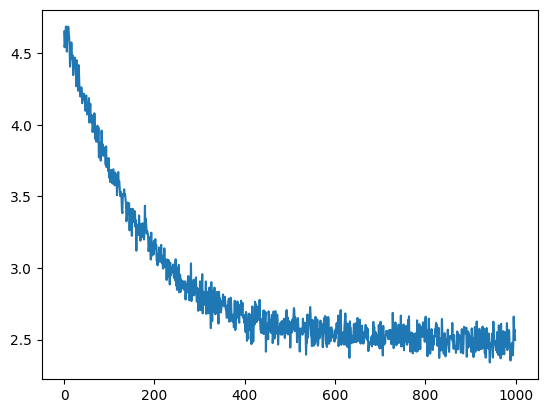

In [11]:
plt.plot(losses)

In [12]:
idx = torch.zeros((1,1), dtype=torch.long).to(device)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


co y inde Miced tlat mangENofowhas
SThind.
UCENGr url hathant me machan fHe.
Fou d iere--sthurore ce


In [35]:
torch.manual_seed(1337)
B,T,C = 4, 8, 32
head_size=16
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 32])

In [51]:
class SelfAttention(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.Wk = nn.Linear(C, head_size, bias=False)
        self.Wq = nn.Linear(C, head_size, bias=False)
        self.Wv = nn.Linear(C, head_size, bias=False)

    def forward(self, x):
        # x: (B,T,C)
        k = self.Wk(x) # (B,T,head_size)
        q = self.Wq(x) # (B,T,head_size)
        v = self.Wv(x)

        tril = torch.tril(torch.ones(x.shape[1], x.shape[1]))
        scores = q @ k.transpose(-2, -1) * head_size**0.5 # (B,T,head_size) @ (B,head_size,T) -> (B, T, T)
        scores = scores.masked_fill(tril == 0, float('-inf'))
        scores = F.softmax(scores, dim=-1)
        out = scores @ v

        return out

attention = SelfAttention()

In [52]:
out = attention(x)
out.shape

torch.Size([4, 8, 16])